# Align projections from a Shepp-Logan phantom volume

In [ ]:
import pyxalign
import matplotlib.pyplot as plt
import numpy as np
import os
from pyxalign_examples import example_utils

### Create simulated projections from Shepp-Logan phantom

In [2]:
n_angles = 750
angles = np.linspace(0, 360, n_angles, dtype=np.float32)
shift = example_utils.get_simulated_displacement_curve(angles)
task = example_utils.get_simulated_phantom_task(angles, shift)

# show the projections object through the GUI
projection_viewer = pyxalign.gui.launch_projection_viewer(task.phase_projections)

projection size [320 384]
(100, 250, 250)


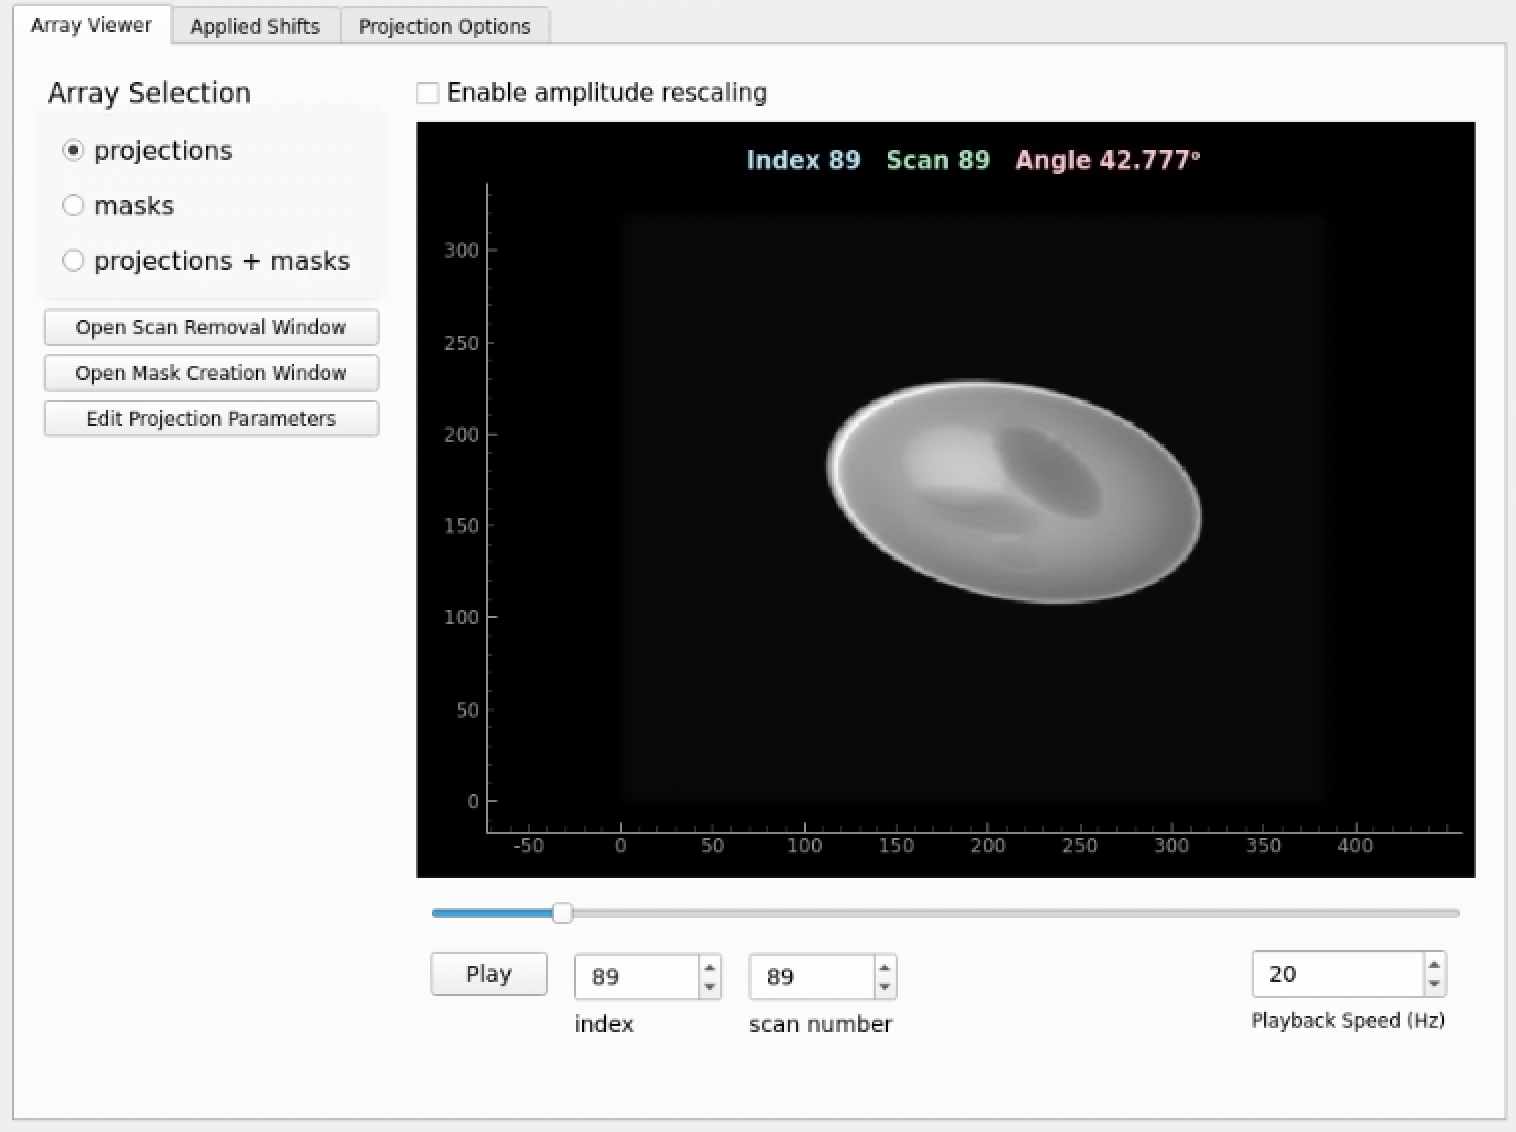

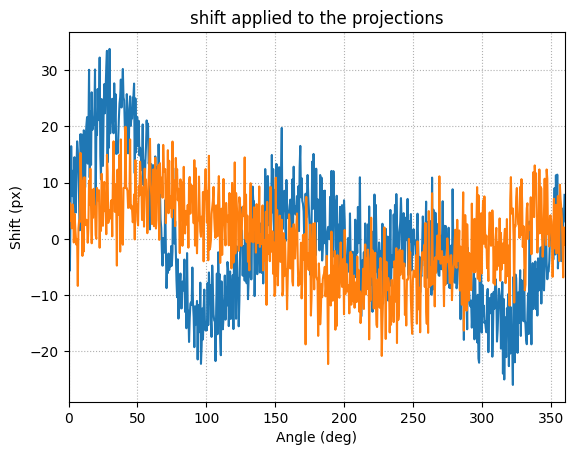

In [5]:
%matplotlib inline
plt.title("shift applied to the projections")
plt.plot(angles, shift)
plt.ylabel("Shift (px)")
plt.xlabel("Angle (deg)")
plt.autoscale(True, "x", True)
plt.grid(ls=":")
plt.show()

### Cross-correlation alignment with GUI
1. Run the cell to open the GUI
2. Click the "start alignment" button
In the GUI window, click the "start alignment button". After the alignment completes,
the pre-alignment and post-alignment views

In [3]:
# launch cross-correlation alignment GUI
task.options.cross_correlation.remove_slow_variation = True
cross_correlation_gui = pyxalign.gui.launch_cross_correlation_gui(task)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]


Cross-correlation shift stored in shift_manager


**The cross-correlation alignment GUI:**

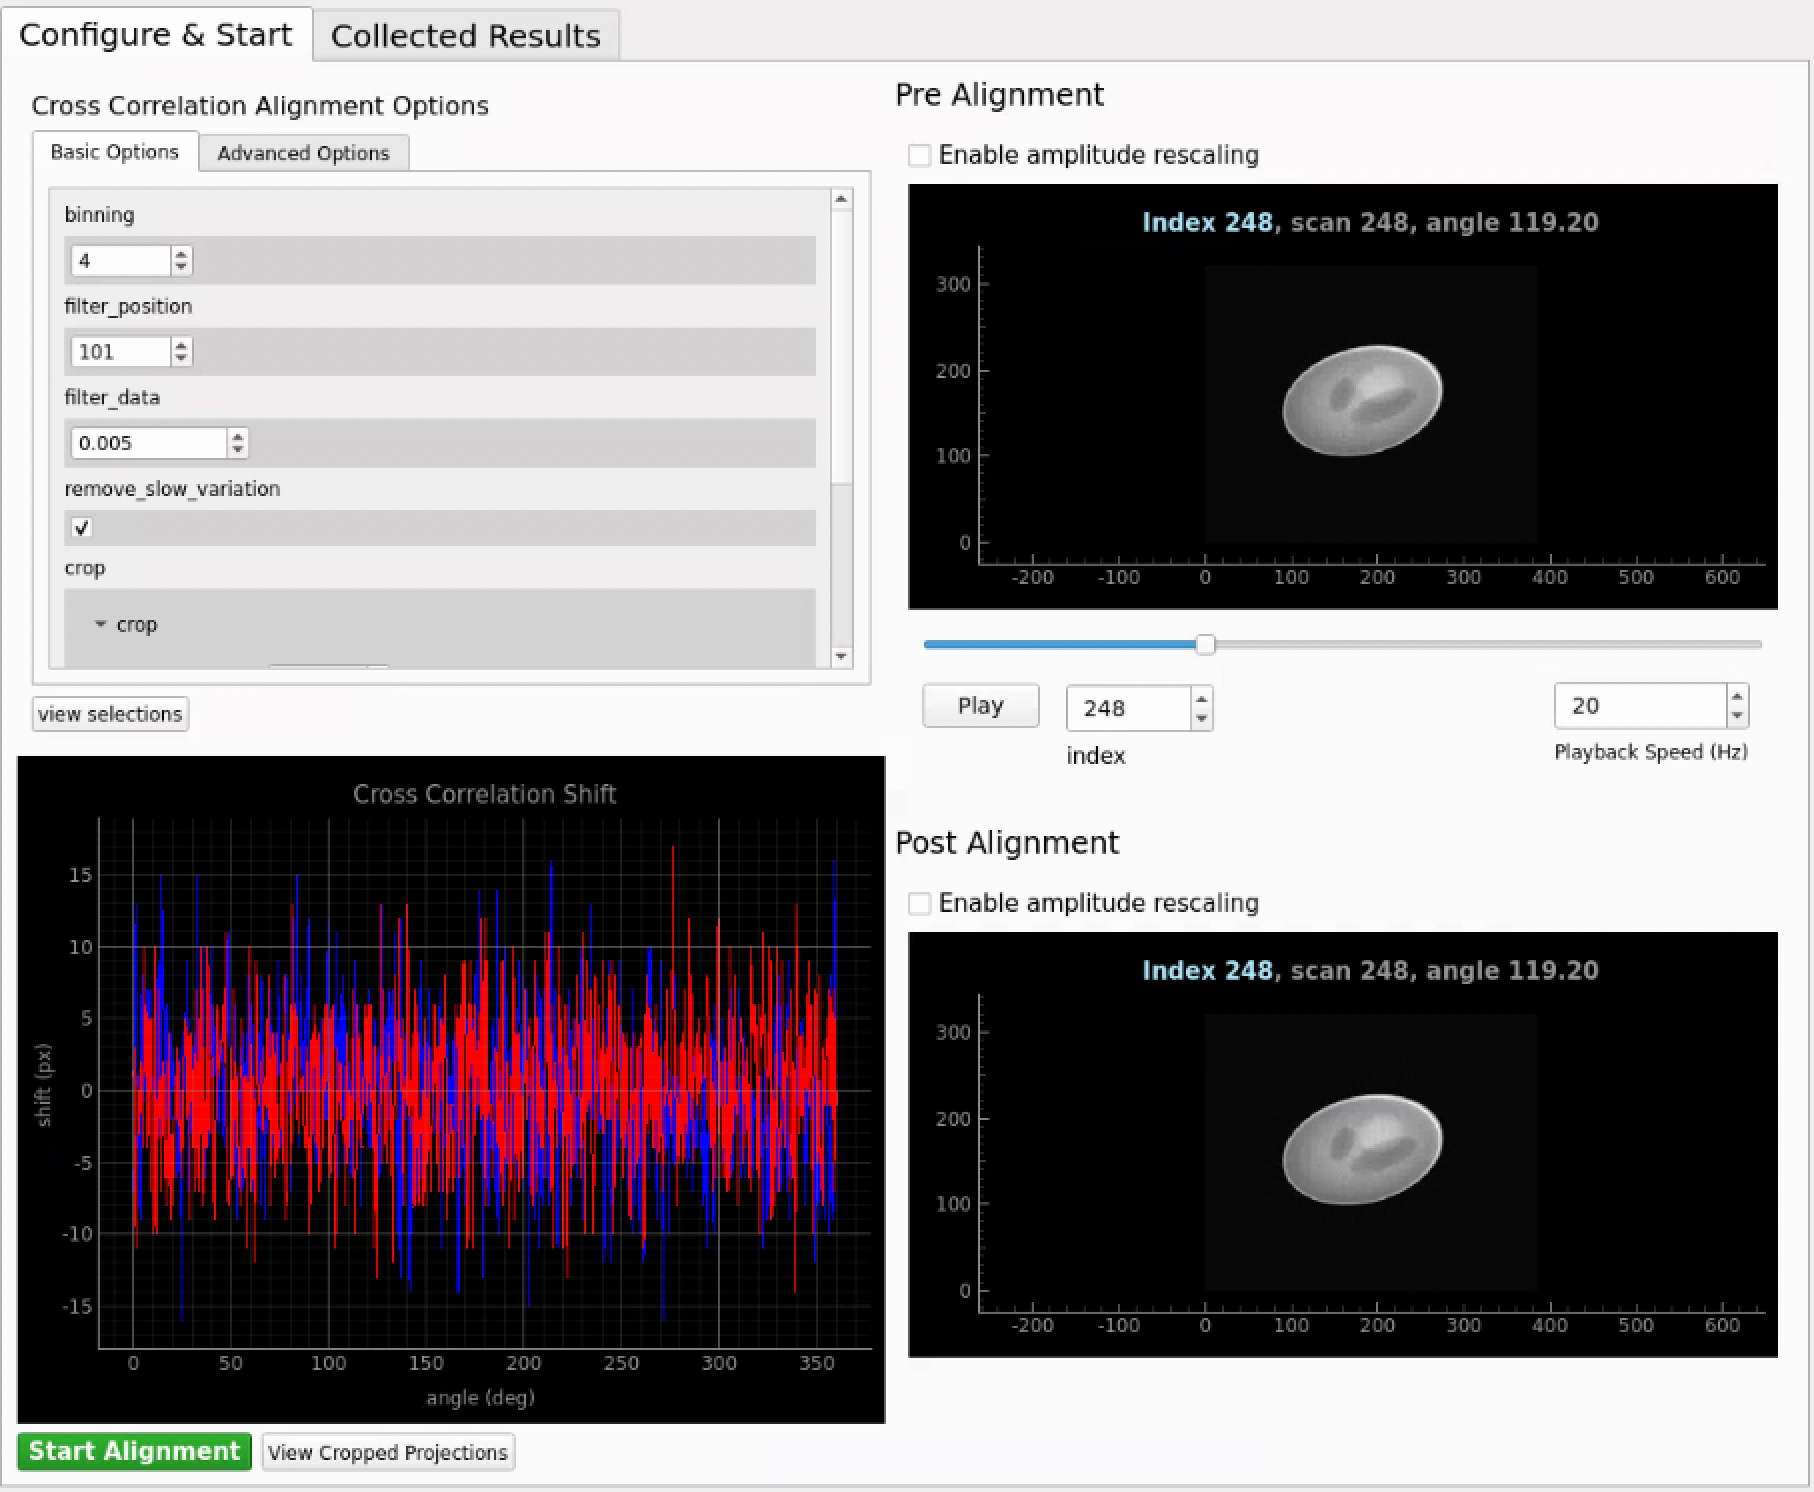

3. Shift the projections by the cross-correlation alignment shift calculated in the last step using the `apply_staged_shift` method

In [4]:
# apply the cross-correlation shift
task.phase_projections.apply_staged_shift()

### Projection-matching alignment

In [5]:
# task.options.projection_matching = pyxalign.options.ProjectionMatchingOptions()
pma_options = task.options.projection_matching
# Turn on pre-alignment downsampling of projections
pma_options.downsample.enabled = True
# Turn on momentum 
pma_options.momentum.enabled = True
# specify gpus to use for back and forward projection
gpu_list = (0,1,2,3)
pma_options.reconstruct.astra.back_project_gpu_indices = gpu_list
pma_options.reconstruct.astra.forward_project_gpu_indices = gpu_list
# select high pass filter value; this is usually chosen empirically
pma_options.high_pass_filter = 0.005
pma_options.iterations = 1000
pma_options.min_iterations = 20
pma_options.keep_on_gpu = True
pma_options.interactive_viewer.update.enabled = True

In [6]:
# initialize a dict for storing the shift after each step
pma_estimated_shift = []

In [7]:
pma_options.downsample.scale = 8
current_shift_estimate = task.get_projection_matching_shift()
pma_estimated_shift += [current_shift_estimate]

image_downsample_linear: 100%|██████████████████| 38/38 [00:00<00:00, 72.25it/s]


Starting projection-matching alignment downsampling = 8...


Max step size update: 0.0097 px Momentum acceleration: [14.82  4.65] Friction: 0


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shift stored in shift_manager


In [8]:
pma_options.downsample.scale = 4
current_shift_estimate = task.get_projection_matching_shift(pma_estimated_shift[-1])
pma_estimated_shift += [current_shift_estimate]

image_downsample_linear: 100%|██████████████████| 38/38 [00:00<00:00, 65.82it/s]


Starting projection-matching alignment downsampling = 4...


Max step size update: 0.0054 px Momentum acceleration: [7.31 2.53] Friction: 0.1


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shift stored in shift_manager


In [9]:
pma_options.downsample.scale = 2
current_shift_estimate = task.get_projection_matching_shift(pma_estimated_shift[-1])
pma_estimated_shift += [current_shift_estimate]

image_downsample_linear: 100%|██████████████████| 38/38 [00:00<00:00, 56.97it/s]


Starting projection-matching alignment downsampling = 2...


Max step size update: 0.0011 px Momentum acceleration: [9.36 3.76] Friction: 0.1


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shift stored in shift_manager


In [10]:
pma_options.downsample.scale = 1
current_shift_estimate = task.get_projection_matching_shift(pma_estimated_shift[-1])
pma_estimated_shift += [current_shift_estimate]

Starting projection-matching alignment downsampling = 1...


Max step size update: 0.0010 px Momentum acceleration: [11.78  4.33] Friction: 0


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shift stored in shift_manager


In [11]:
pma_options.downsample.scale = 1
pma_options.high_pass_filter = 0.01
pma_options.step_relax = 0.5
pma_options.momentum.enabled = False
current_shift_estimate = task.get_projection_matching_shift(pma_estimated_shift[-1])
pma_estimated_shift += [current_shift_estimate]

Starting projection-matching alignment downsampling = 1...


Max step size update: 0.0000 px :   2%|▏      | 19/1000 [00:31<27:26,  1.68s/it]


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shift stored in shift_manager


**Projection Matching Alignment Viewer:**

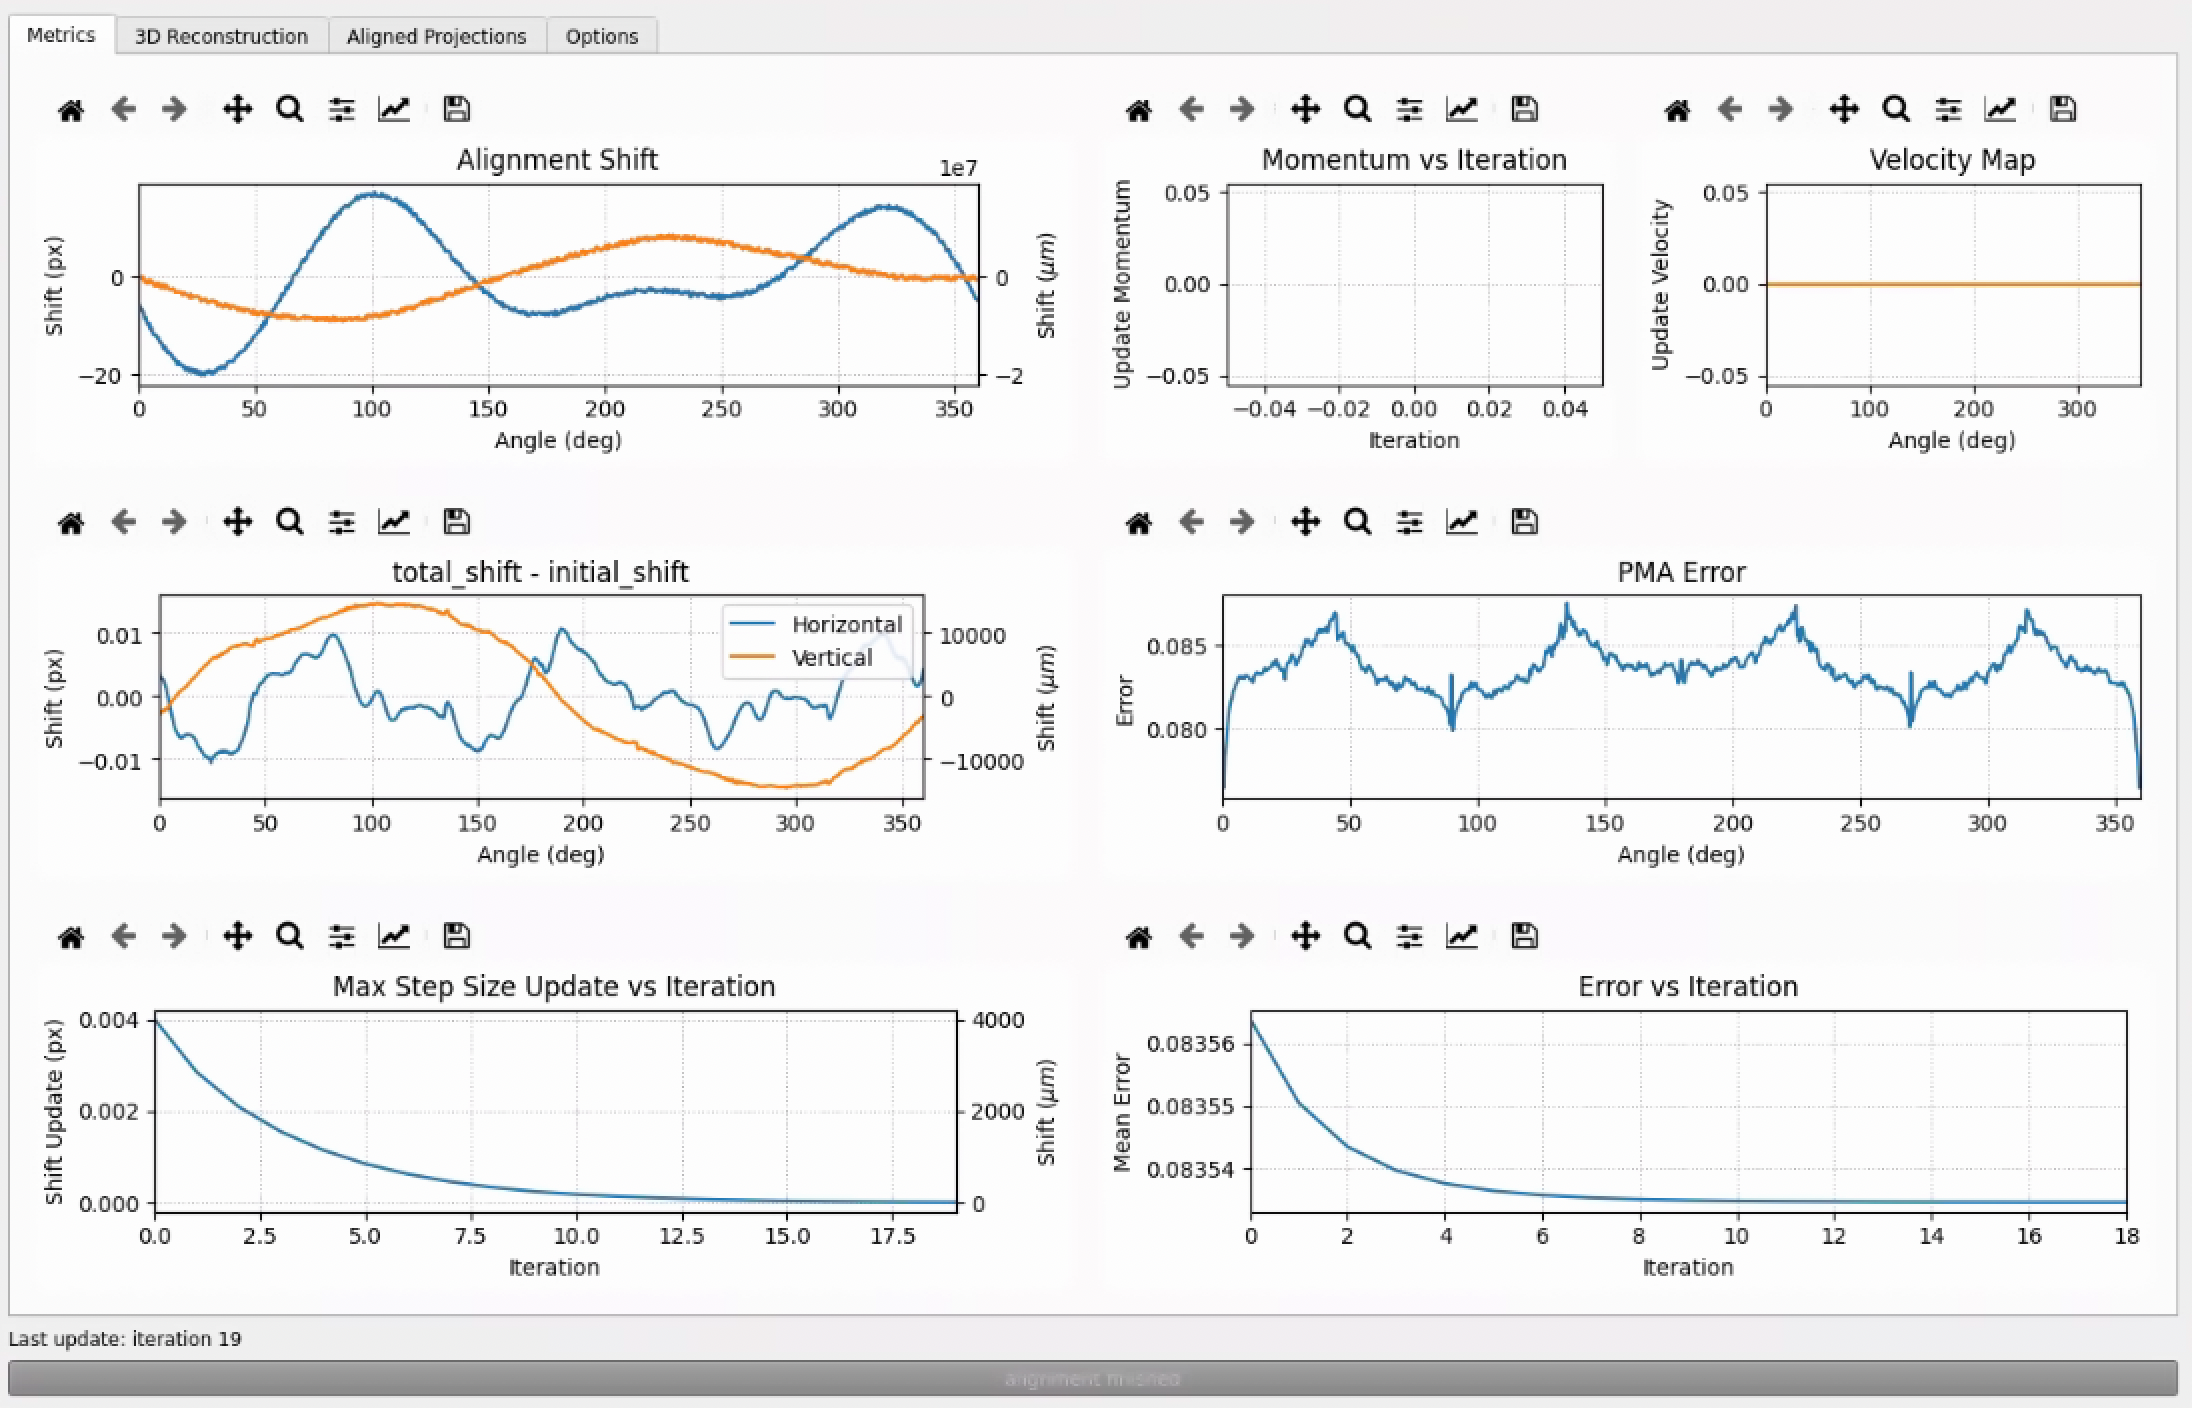

In [12]:
# apply PMA estimated shift to projections
task.phase_projections.apply_staged_shift()

### Reconstruct 3D volume

In [13]:
task.phase_projections.get_3D_reconstruction()

In [14]:
# view the volume
gui = pyxalign.gui.launch_volume_viewer(task.phase_projections.volume.data)

**Volume viewer:**

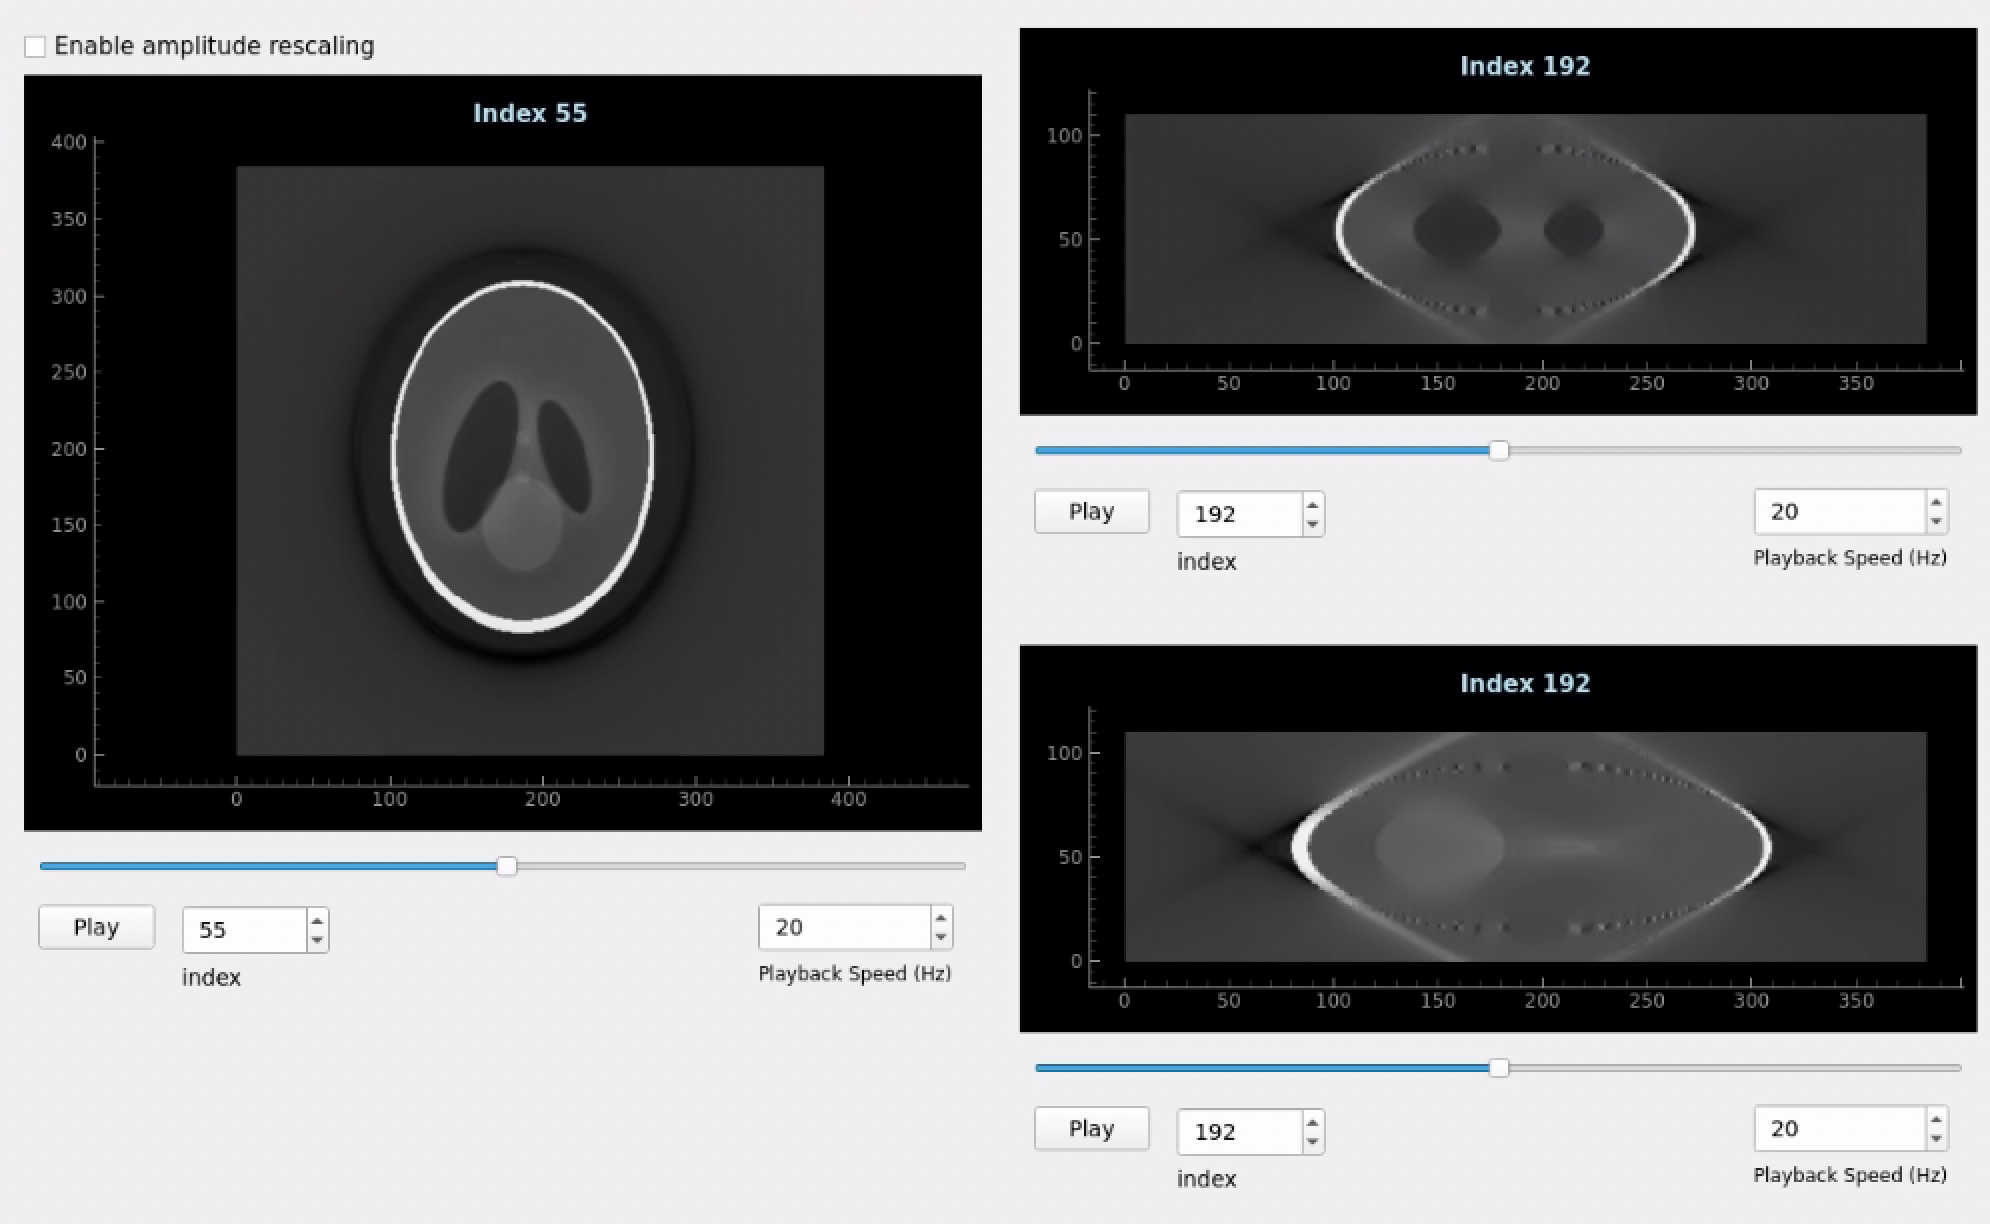

### Save results

In [15]:
# specify where to save data to
save_folder = "/local/hruth/phantom_alignment_results/"

In [19]:
# save volume to tiff file
save_path = os.path.join(save_folder, "aligned_volume.tiff")
task.phase_projections.volume.save_as_tiff(save_path)

# save volume to h5 file
save_path = os.path.join(save_folder, "aligned_volume.h5")
task.phase_projections.volume.save_as_h5(save_path)

File saved to: /local/hruth/phantom_alignment_results/aligned_volume.tiff
File saved to: /local/hruth/phantom_alignment_results/aligned_volume.h5


**Use the `save_task` method to save the aligned task**

In [20]:
save_path = os.path.join(save_folder, "aligned_task.h5")
task.save_task(save_path)

projections saved to /local/hruth/phantom_alignment_results/aligned_task.h5/phase_projections
task saved to /local/hruth/phantom_alignment_results/aligned_task.h5/


### Inspect error on the shift
This section is for evaluating how well the alignment worked on the simulated data

The final estimated displacement is not the same as the displacement applied to the projections earlier. There are infinite solutions where the aligned projections precess around the center of rotation; this does not affect the quality of the reconstructed volume, it just means that the reconstruct volume will be shifted in the xy-plane.

To calculate the true error in the final estimated displacement we need to fit to the underlying precession, `example_utils.get_true_displacement_residual` does this.

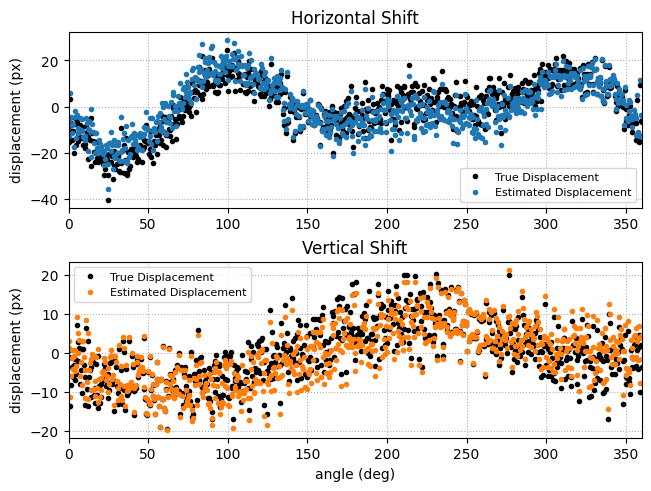

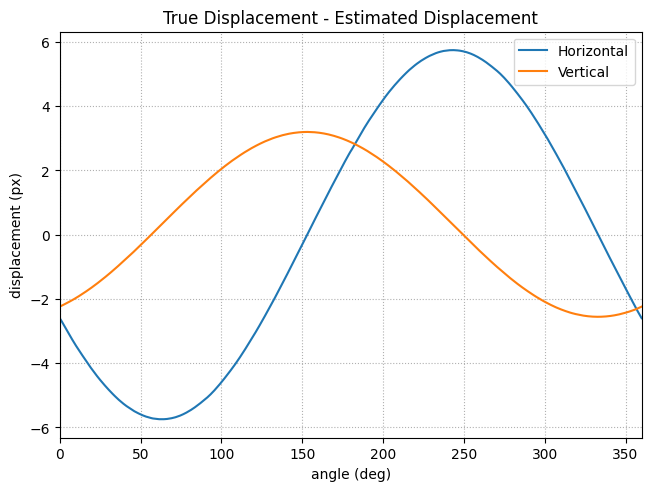

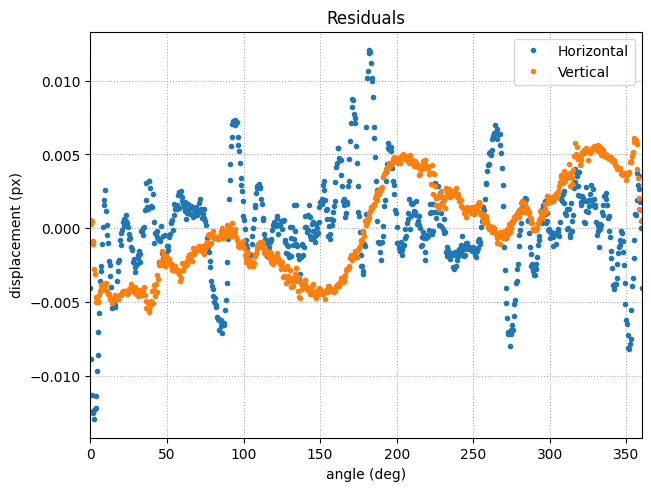

In [21]:
cross_correlation_shift = task.phase_projections.shift_manager.past_shifts[1]
estimated_shift = current_shift_estimate + cross_correlation_shift
%matplotlib inline
residuals = example_utils.get_true_displacement_residual(
    true_displacement=-shift,
    estimated_displacement=estimated_shift,
    angles=task.phase_projections.angles,
)

### Reload Data

**Use the `load_task` function to reload a saved task**

In [22]:
# to reload this task file with the aligned projections, use the
# load_task 
load_path = os.path.join(save_folder, "aligned_task.h5")
task = pyxalign.data_structures.load_task(load_path)

Loading task from /local/hruth/phantom_alignment_results/aligned_task.h5 ...
Loading complete
